In [1]:
MODEL_ID = "llava-hf/llama3-llava-next-8b-hf"

In [2]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained(MODEL_ID)
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
model = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [12:38<00:00, 189.74s/it]


In [3]:
import datasets

ds = datasets.load_dataset("AWeirdDev/screen-qa-complex")
ds = ds["train"].select(range(20))
# def add_features(sample):
#     size = sample["image"].size
#     sample["image_size"] = size
#     sample["landscape"] = size[0] > size[1]
#     return sample
# num_proc=6 took 6m40s
# ds = ds.map(add_features)
ds


Dataset({
    features: ['image', 'question', 'ground_truth'],
    num_rows: 20
})

In [39]:
# prepare image and prompt for the model
i = 5

image = ds[i]["image"]
question = ds[i]["question"]
answer = ds[i]["ground_truth"]
conversation = [
    {
        "role": "system",
        "content": [
            {"type": "text", "text": "Answer as short as possible."},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": question},
        ],
    }
]
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(text=text_prompt, images=[image], return_tensors="pt").to("cuda")

for k,v in inputs.items():
    print(k,v.shape)

input_ids torch.Size([1, 30])
attention_mask torch.Size([1, 30])
pixel_values torch.Size([1, 5, 3, 336, 336])
image_sizes torch.Size([1, 2])


In [40]:
MAX_LENGTH=256
# Generate token IDs
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [41]:
print(question)

How many workout plans are offered?


In [42]:
print(generated_texts[0].split("assistant\n\n\n")[-1])

The image shows a mobile app interface with a section titled "Health Plans." There are three workout plans offered, as indicated by the icons and labels:

1. Technique
2. Strength
3. Cardio

Each workout plan has a corresponding slider that can be adjusted to indicate the user's level of engagement or interest in that particular plan. The sliders are currently set to the minimum level, as indicated by the sliders being at the bottom of their range.


In [43]:
print(answer)

3


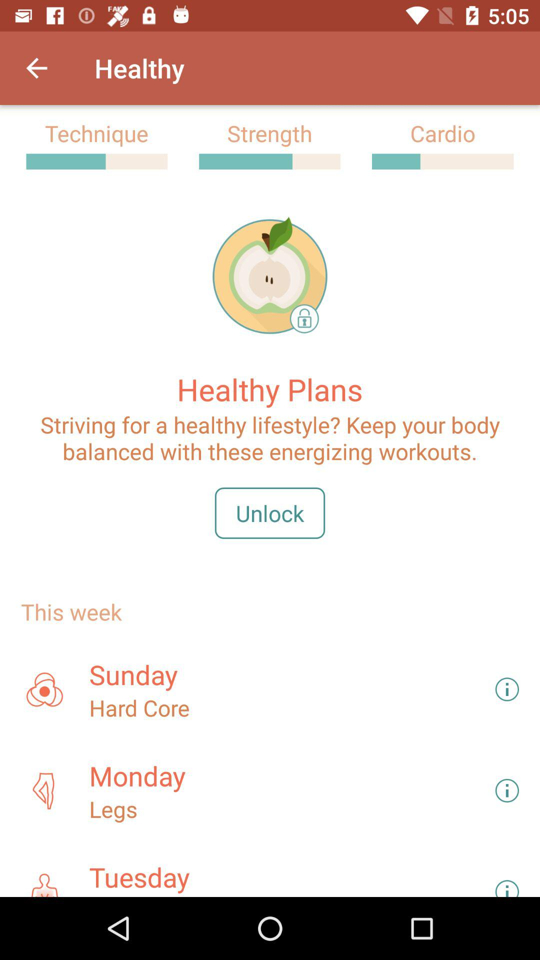

In [44]:
image.resize((int(image.size[0] * 0.5), int(image.size[1] * 0.5)))